In [119]:
import sys; sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
import os
from src.simple_utils import load_pickle
from src.data_utils import cifar10_label_names, get_dataset
from os.path import join
from cifarclass import cifar100_classes

label_mapping=cifar100_classes
classes = list(label_mapping.values())

In [63]:
name = "CIFAR100_test"
# name of training dataset
train_set = "CIFAR100_train"

print("loading data")
grouped = load_pickle('../processed/cifar100/clip_new/group2.pkl')
scores = load_pickle('../processed/cifar100/clip_new/scores.pkl')
print("done")

print("loading dataset")
dataset = get_dataset('data', name)
ytest = np.array(dataset.targets)
print("done")


loading data
done
loading dataset
Files already downloaded and verified
done


In [3]:
grouped['CIFAR100_test']['ClipViTB32'].keys()

dict_keys(['x', 'x_err', 'points', 'points_err', 'labels', 'labels_err', 'probs', 'freqs', 'x_smooth', 'points_smooth'])

In [83]:
# preprocessing: compute soft-accuracies
def probs_to_softacc(probs):
    return np.array([probs[i, yi, :] for i, yi in enumerate(ytest)]).mean(0)

softacc = probs_to_softacc(grouped[name]['ClipViTB32']['probs'])
softacc

array([0.01084949, 0.01244471, 0.0144032 , 0.01669697, 0.0193657 ,
       0.02243982, 0.02595723, 0.02990744, 0.03434641, 0.03931442,
       0.04695878, 0.05258518, 0.05847045, 0.06468074, 0.0710883 ,
       0.07782506, 0.08465525, 0.09174713, 0.09907939, 0.10635133,
       0.11523648, 0.1207576 , 0.12621115, 0.13156681, 0.13685334,
       0.14216956, 0.14753905, 0.15276745, 0.15788014, 0.16295202,
       0.16800012, 0.17076534, 0.17348523, 0.17614302, 0.1787424 ,
       0.18133631, 0.1838719 , 0.18641566, 0.18907605, 0.19164532,
       0.19349599, 0.19416292, 0.19487755, 0.1955575 , 0.19624345,
       0.1968925 , 0.19757326, 0.19895945, 0.19964124], dtype=float32)

In [55]:
grouped['CIFAR100_test']['ClipViTB32']['probs'].shape

(10000, 100, 49)

In [168]:
indices = np.random.default_rng(1).choice(np.arange(10000), size=10)

In [17]:
num_figs = 10
alpha =0.2 
markersize=12

index 892


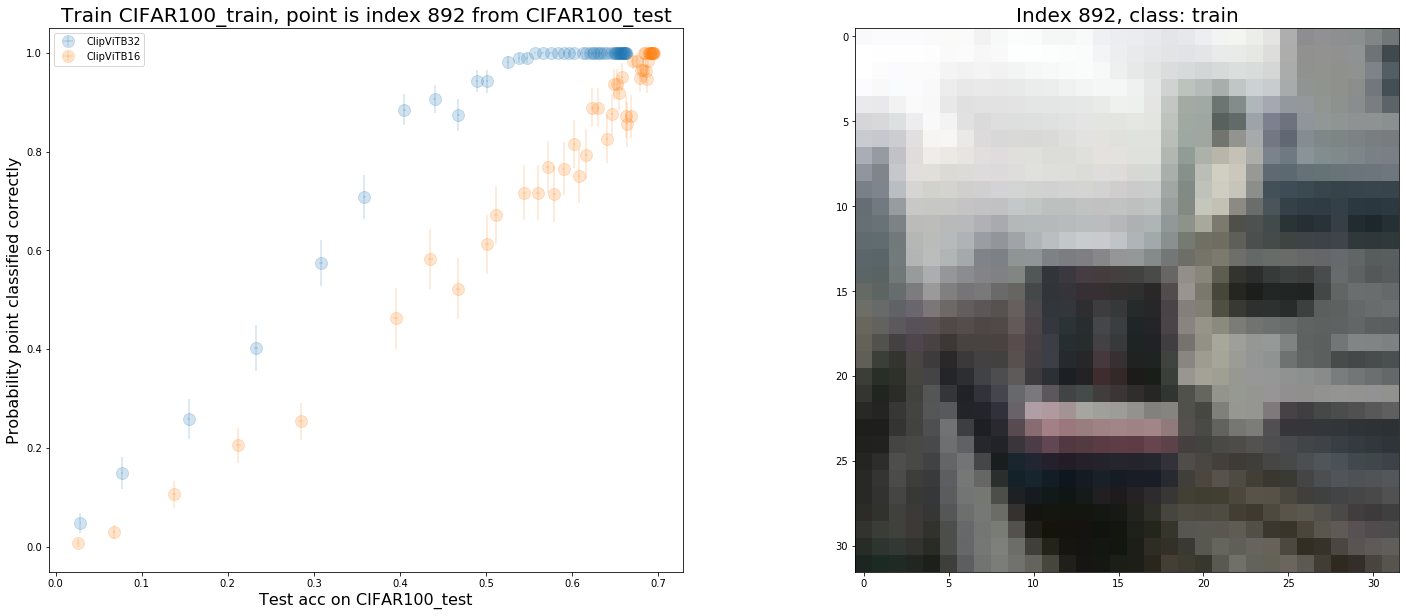

index 7739


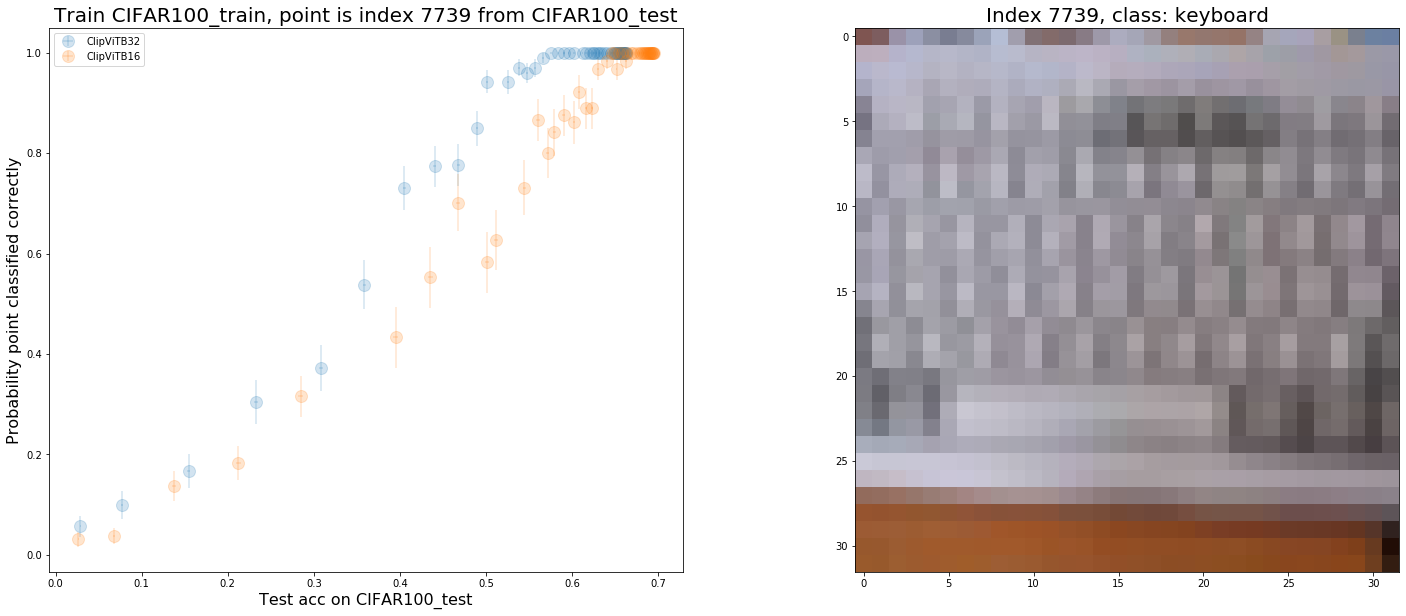

index 6545


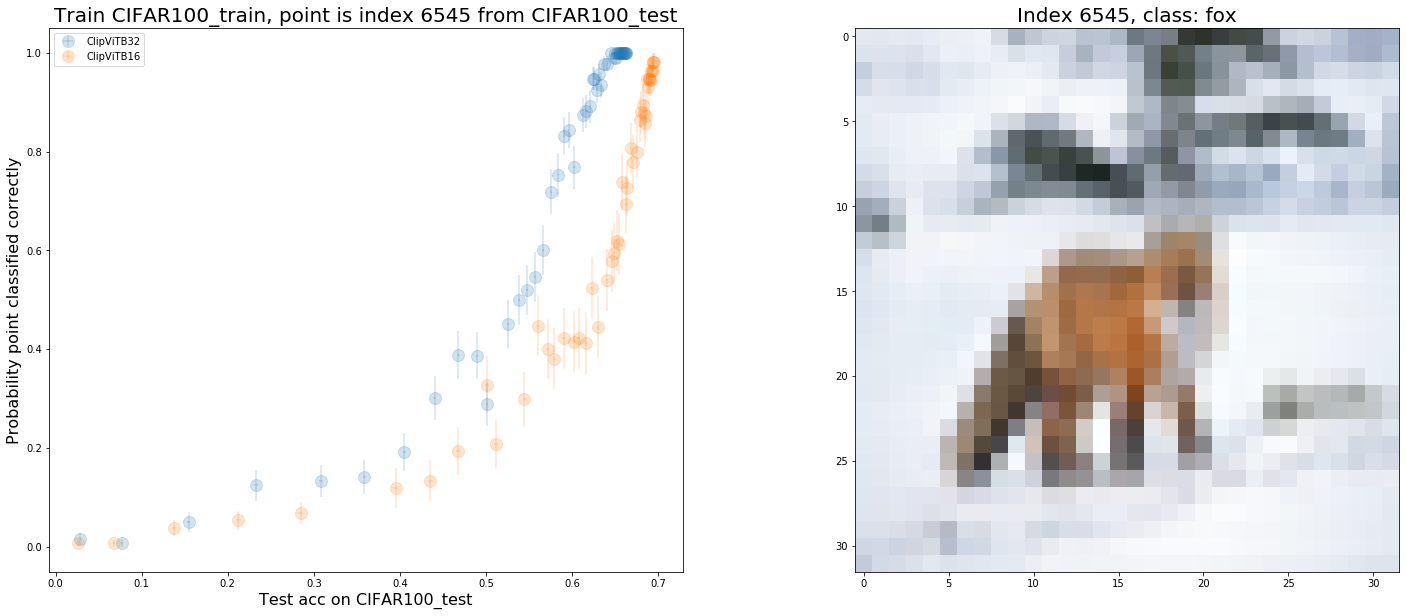

In [35]:
for idx in indices[:3]:
    print("index %d" % idx)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
    for plot_group in grouped[name]:
        dct = grouped[name][plot_group]
        ax1.errorbar(
            dct["x"],
            dct["points"][idx],
            yerr=dct["points_err"][idx],
            xerr=dct["x_err"],
            fmt='o',
            alpha=alpha,
            markersize=markersize,
            label=plot_group,
        )

    ax1.set_xlabel("Test acc on %s" % name, fontsize=16)
    ax1.set_ylabel("Probability point classified correctly", fontsize=16)
    ax1.set_title(
        "Train %s, point is index %d from %s" % (train_set, idx, name),
        fontsize=20,
    )

    ax1.legend(loc="best")
    img, label = dataset.__getitem__(idx)
    img = np.array(img)
    ax2.imshow(img, interpolation="nearest")
    ax2.set_title("Index %d, class: %s" % (idx, classes[label]), fontsize=20)
    plt.show()


In [169]:
import seaborn as sns
import colorcet as cc
from ipdb import set_trace

def cut_labels(y, labels, k=8):
    good = np.argpartition(np.sum(y, axis=1), -k)[-k:]
    bad = set(range(100)).difference(set(list(good)))
    for i in bad:
        labels[i] = '_nolegend_'
    return labels

def stackplot(index, types = ["probs","freqs"], plot_group = "ClipViTB32"):
    dct = grouped[name][plot_group]
    print("index %d" % index)
    img, label = dataset.__getitem__(index)
    img = np.array(img)
    col = sns.color_palette(cc.glasbey, n_colors=25)

    for t in types:
        print(t)
        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
        y = dct[t][index].copy() # probs/freqs
        
        ind = np.argsort(y[:,-1])[::-1] # sort labels according to their final probabilities
        #set_trace()
        print(f"Top 5 are {ind[:5]}")
        print(f"Prediction is {classes[ind[0]]}")
        y = y[ind]
        labels = [classes[ind[i]] for i in range(len(classes))]
        new_label = list(ind).index(label)
        
        # swap in the true-label as the first label in list (and in y)
        labels[0], labels[new_label] = labels[new_label], labels[0]
        y[[0,new_label]] = y[[new_label,0]]
        
        #truth = classes[label]
        labels = cut_labels(y, labels)
        #labels[0] = truth
        

            
        if t=="probs":
            xx = probs_to_softacc(dct["probs"])
            ax1.set_xlabel("Soft-Test acc on %s" % name, fontsize=16)
            ax1.set_ylabel("Softmax probabilities", fontsize=16)
        
        else:
            xx = dct["x"]
            ax1.set_xlabel("Test acc on %s" % name, fontsize=16)
            ax1.set_ylabel("Frequency of predictions", fontsize=16)
            
        
        ax1.stackplot(xx, y, labels=labels, colors = col)
        ax1.set_title(
            "Train %s, architecture %s" % (train_set, plot_group),
            fontsize=20,
        )

        ax1.legend(loc="best")
        ax2.imshow(img, interpolation="nearest")
        ax2.set_title("Index %d from %s, class: %s" % (index, name, classes[label]), fontsize=20)
        plt.show()

index 4731
probs
Top 5 are [89 81 13 58 12]
Prediction is tractor


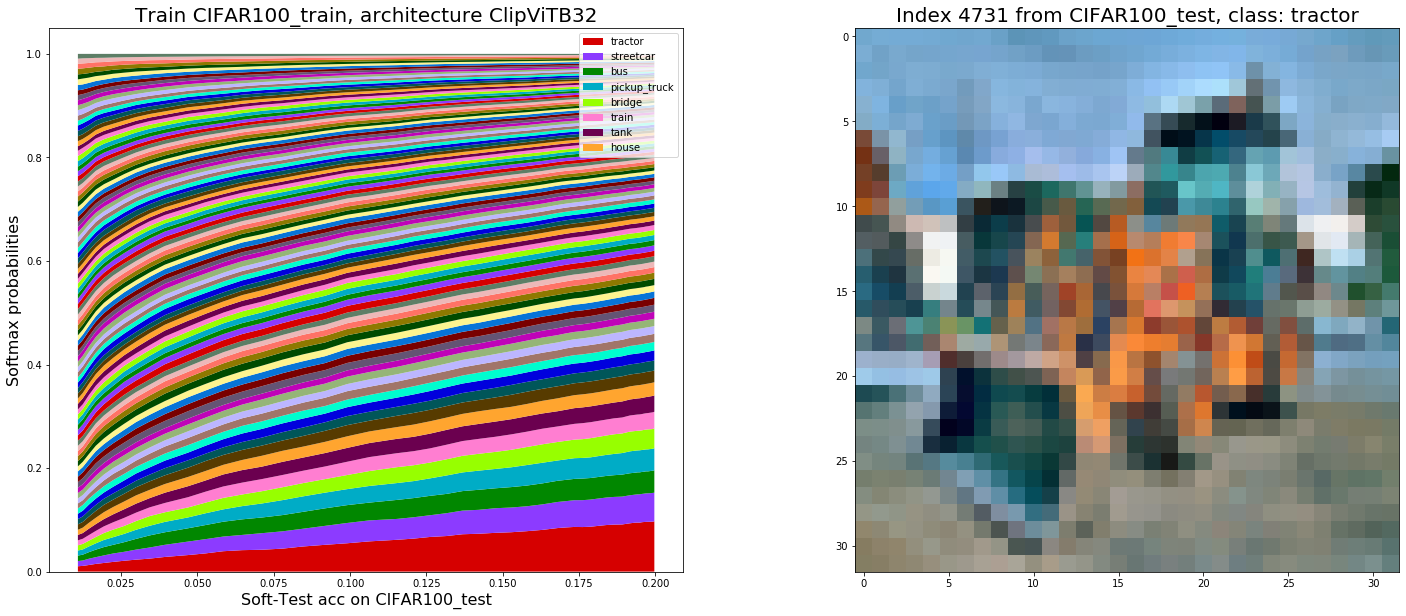

freqs
Top 5 are [89 99 36 26 27]
Prediction is tractor


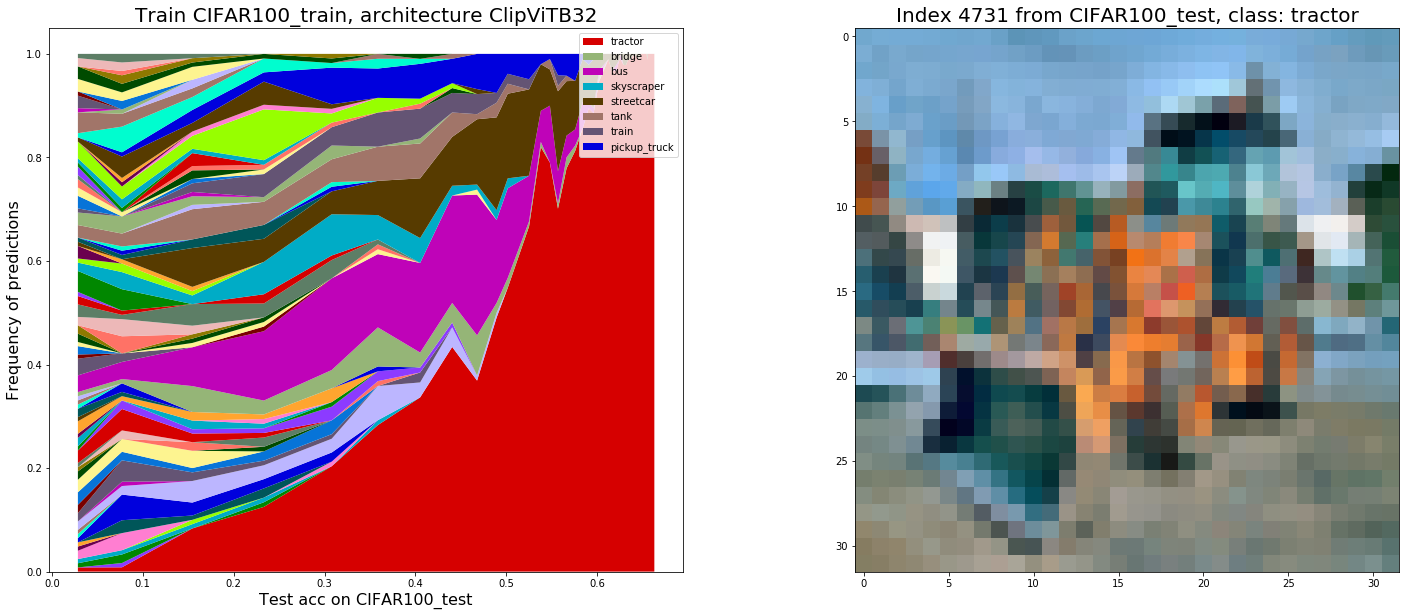

index 5118
probs
Top 5 are [11 98 35 46  2]
Prediction is boy


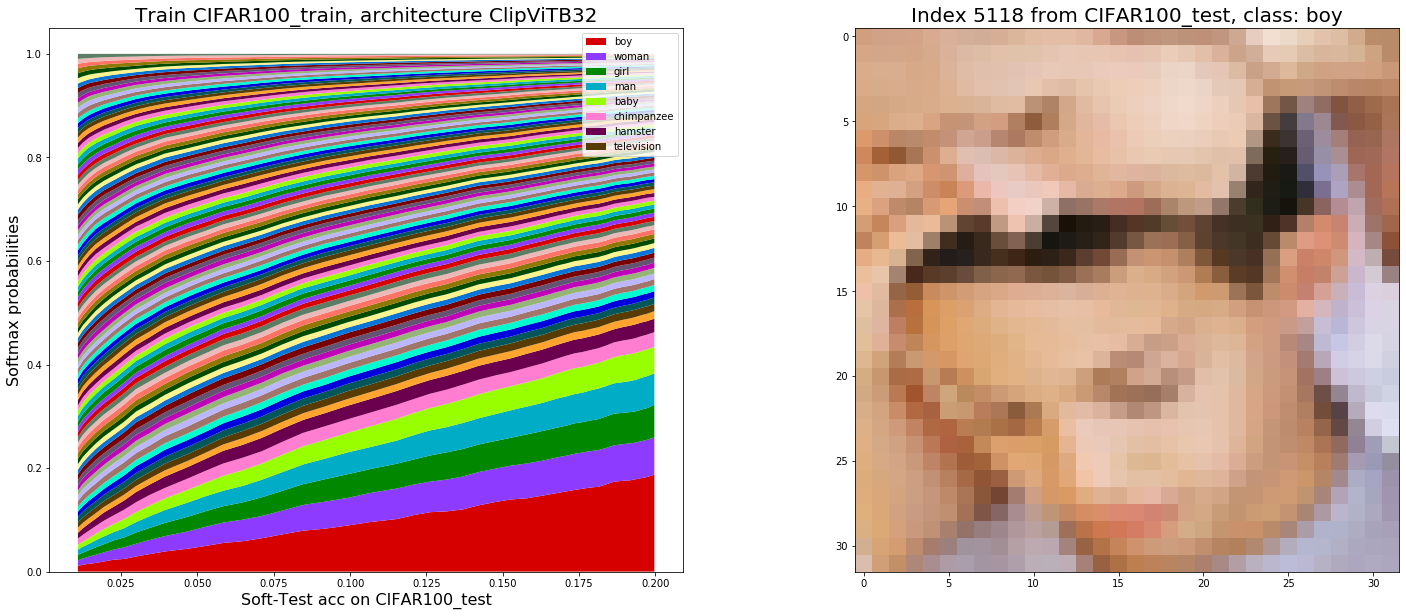

freqs
Top 5 are [11 37 27 28 29]
Prediction is boy


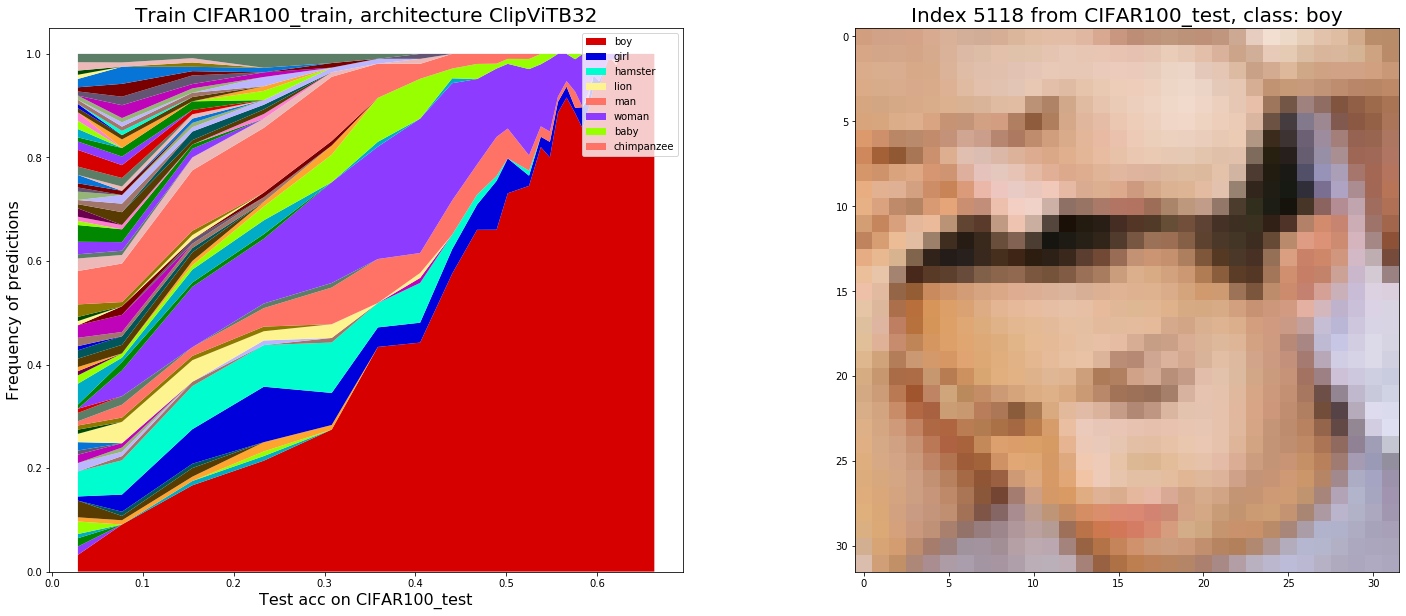

index 7551
probs
Top 5 are [12 71 90 60 81]
Prediction is bridge


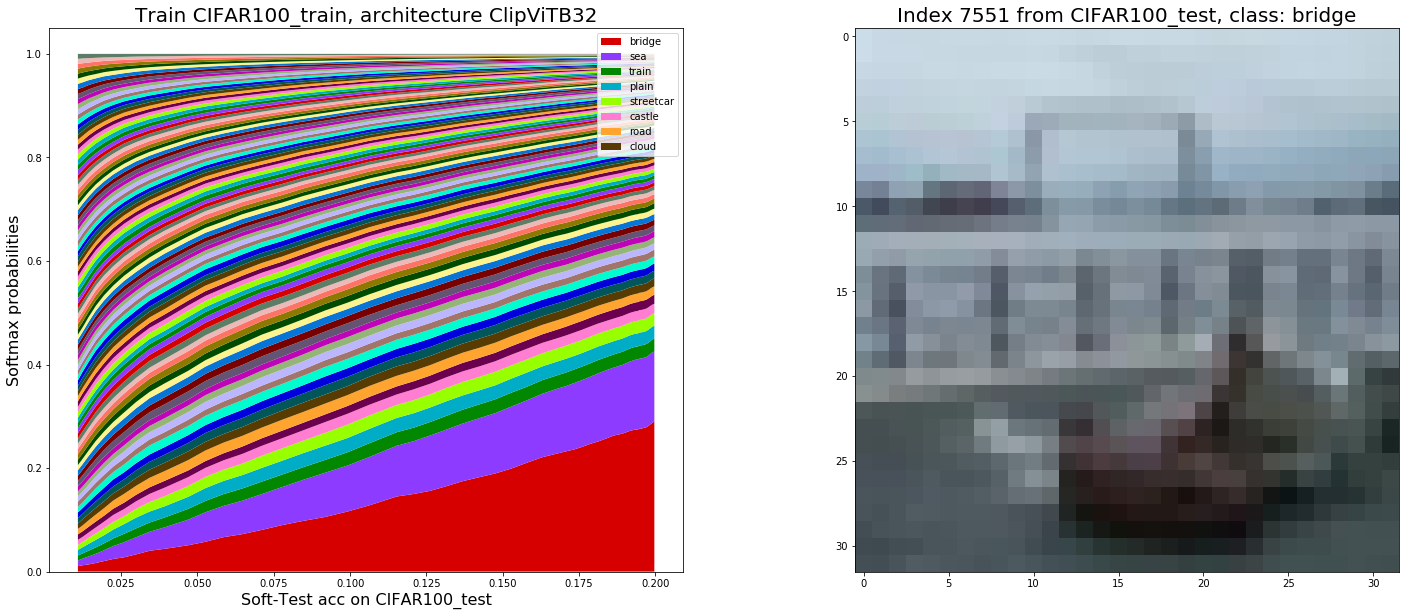

freqs
Top 5 are [12 99 27 28 29]
Prediction is bridge


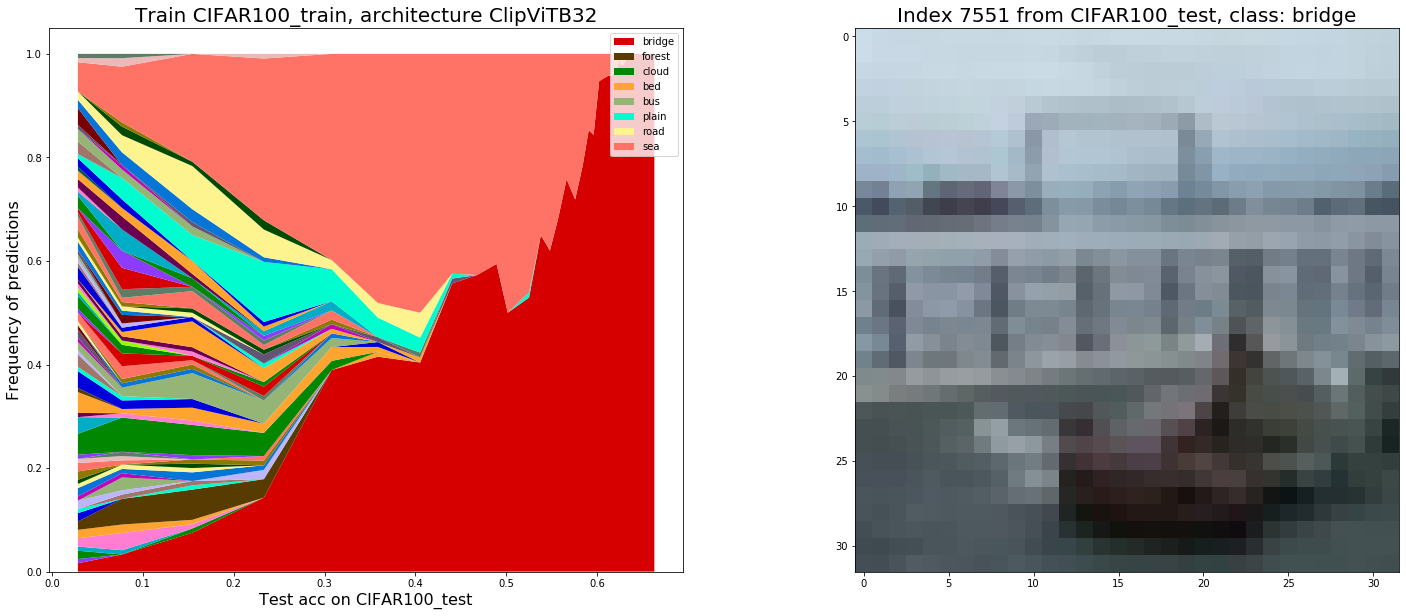

index 9504
probs
Top 5 are [58 89 13 41 68]
Prediction is pickup_truck


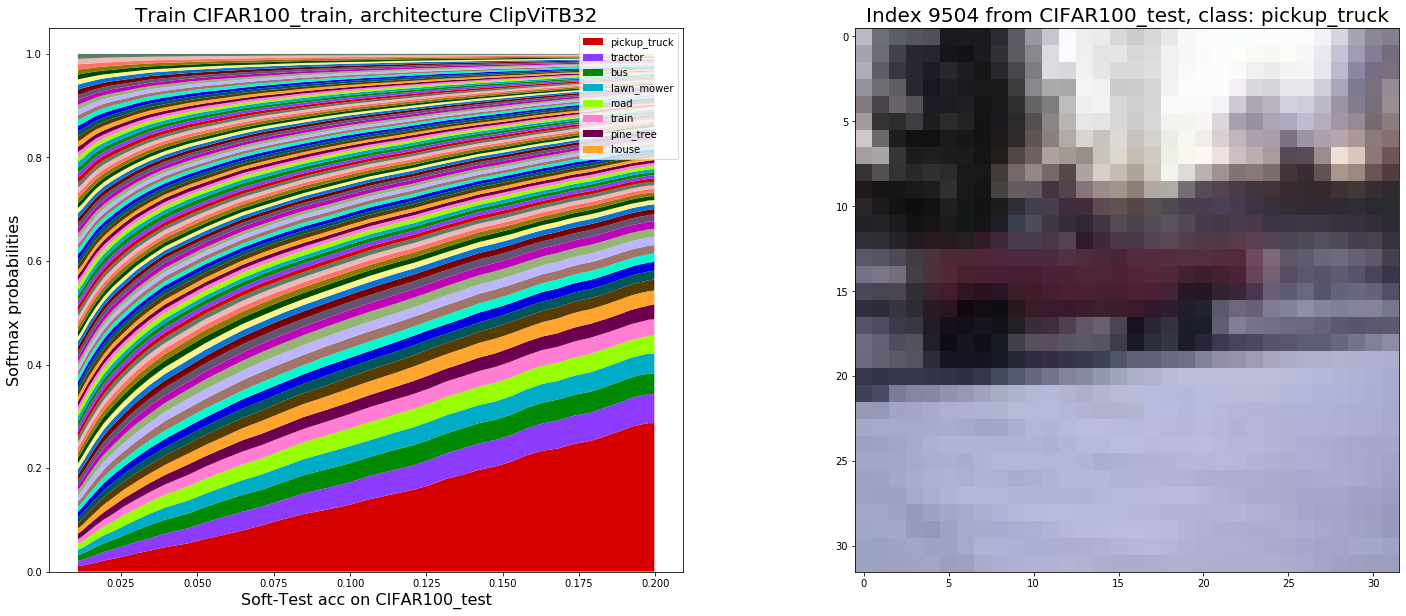

freqs
Top 5 are [58 99 36 26 27]
Prediction is pickup_truck


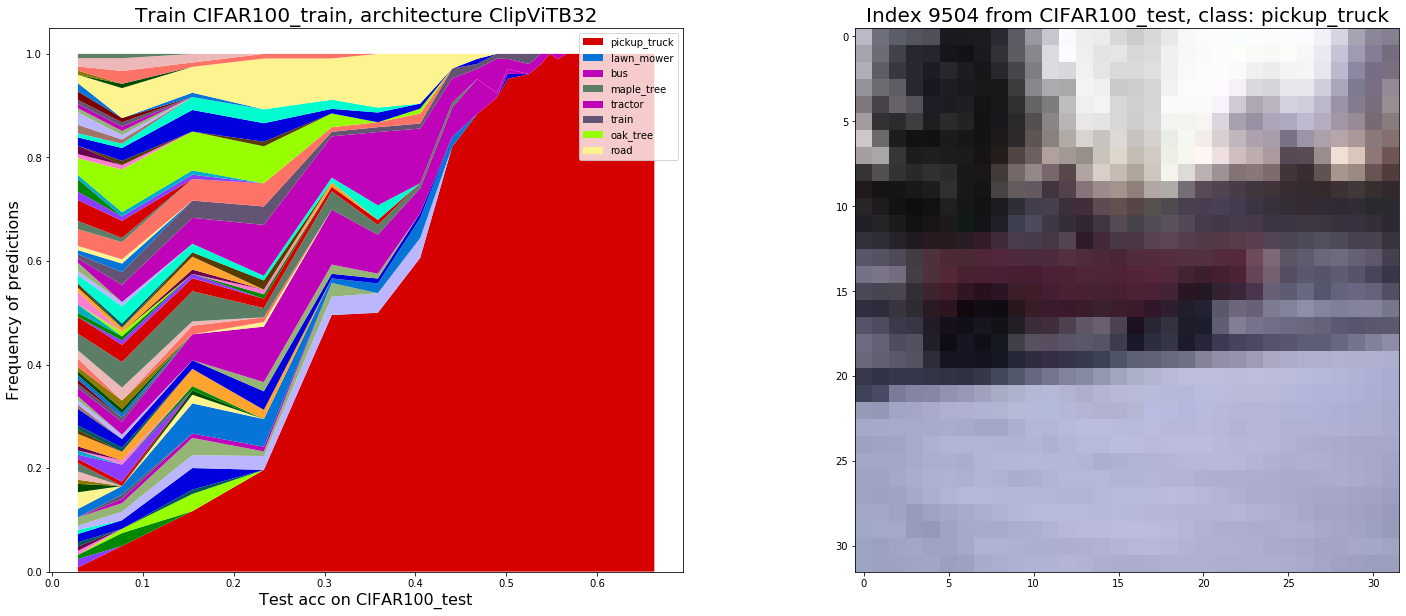

index 348
probs
Top 5 are [ 1 67 10 61 45]
Prediction is aquarium_fish


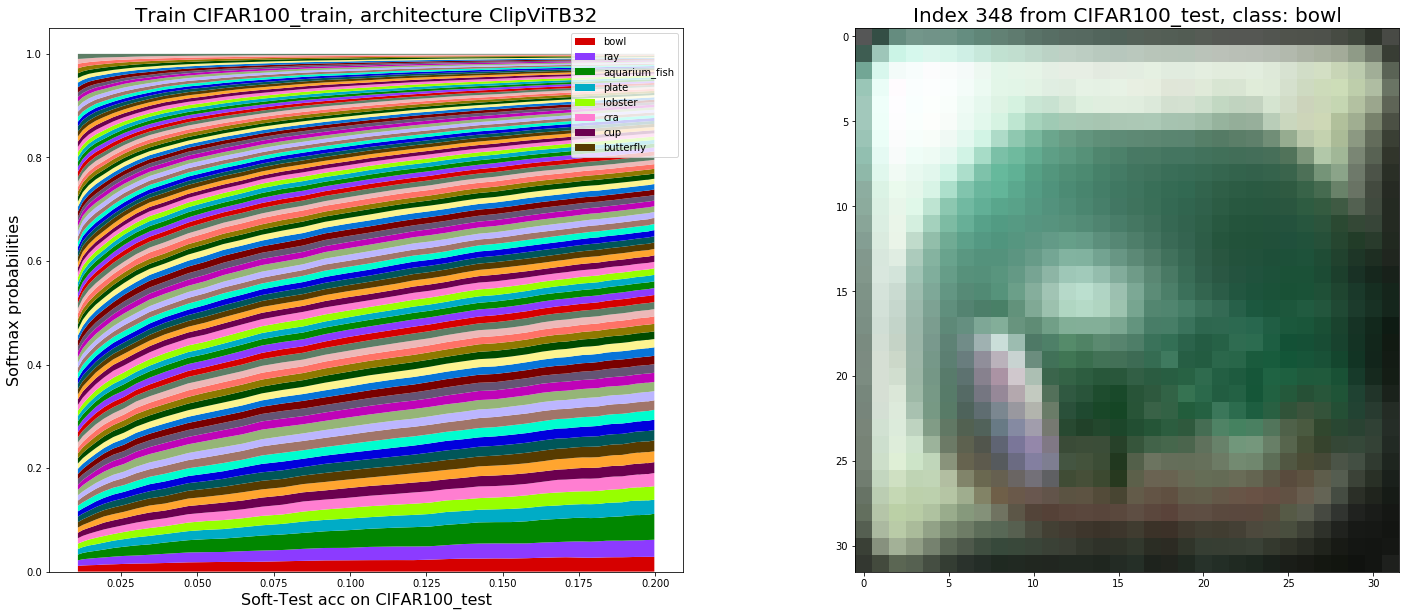

freqs
Top 5 are [ 1 99 37 27 28]
Prediction is aquarium_fish


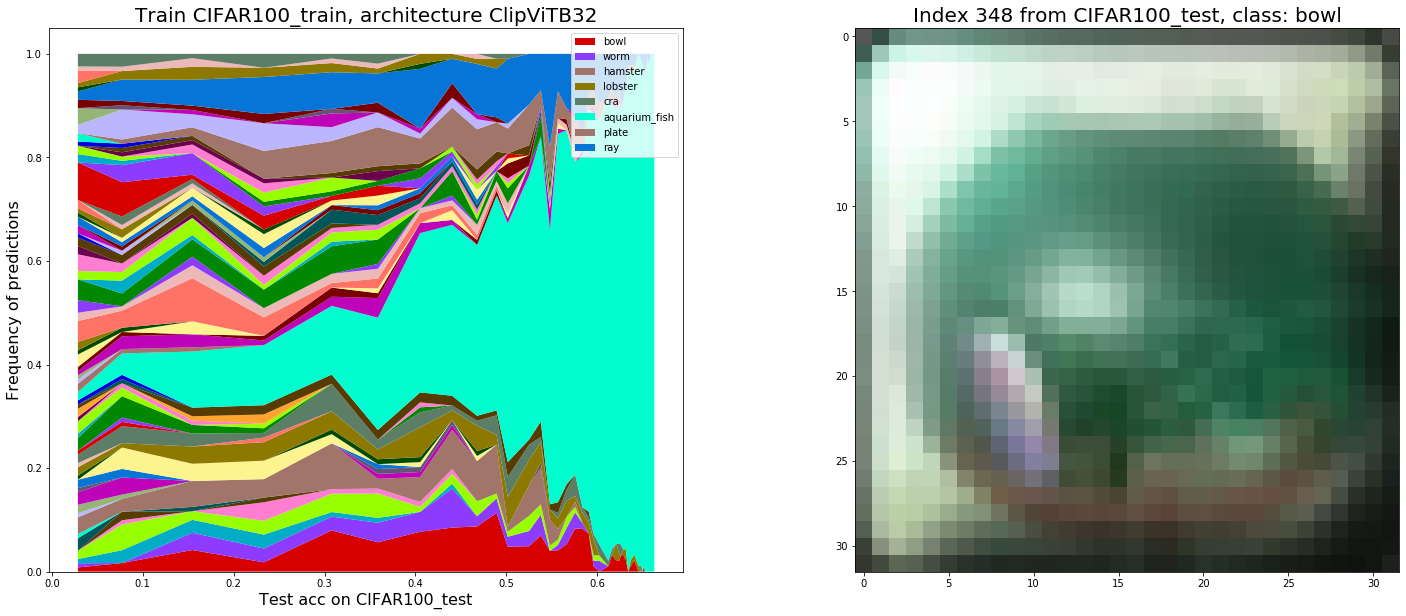

index 1441
probs
Top 5 are [57 53  0 10 83]
Prediction is pear


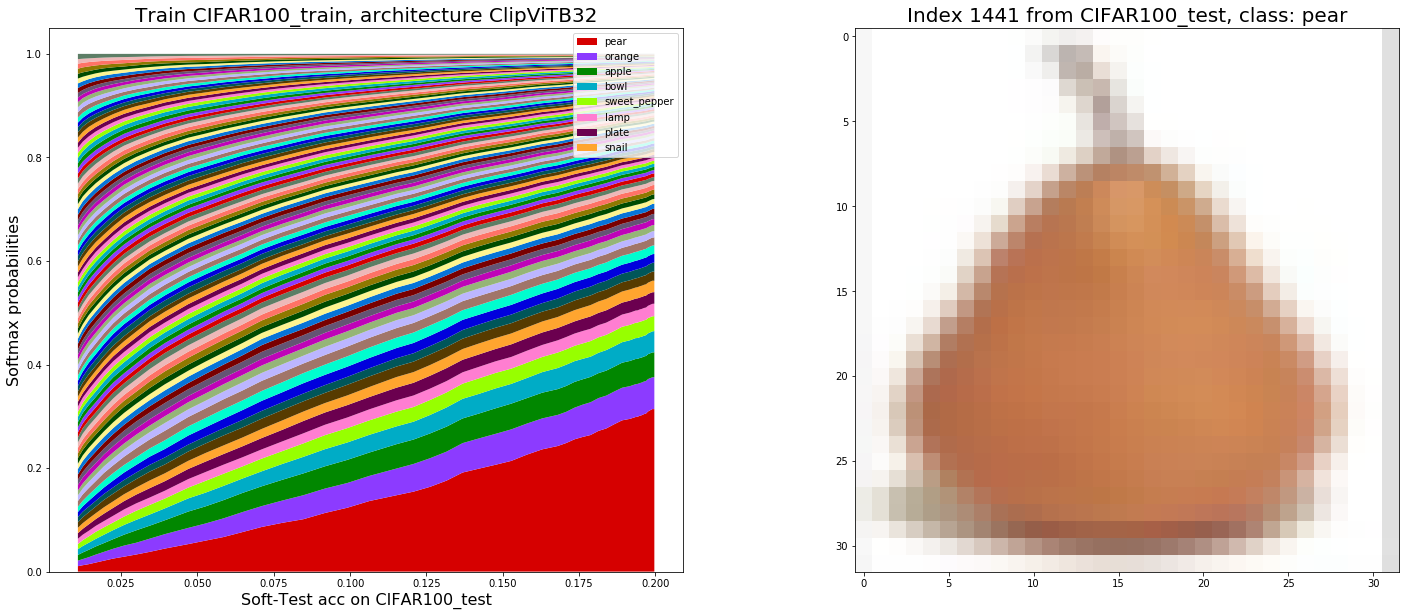

freqs
Top 5 are [57 99 36 26 27]
Prediction is pear


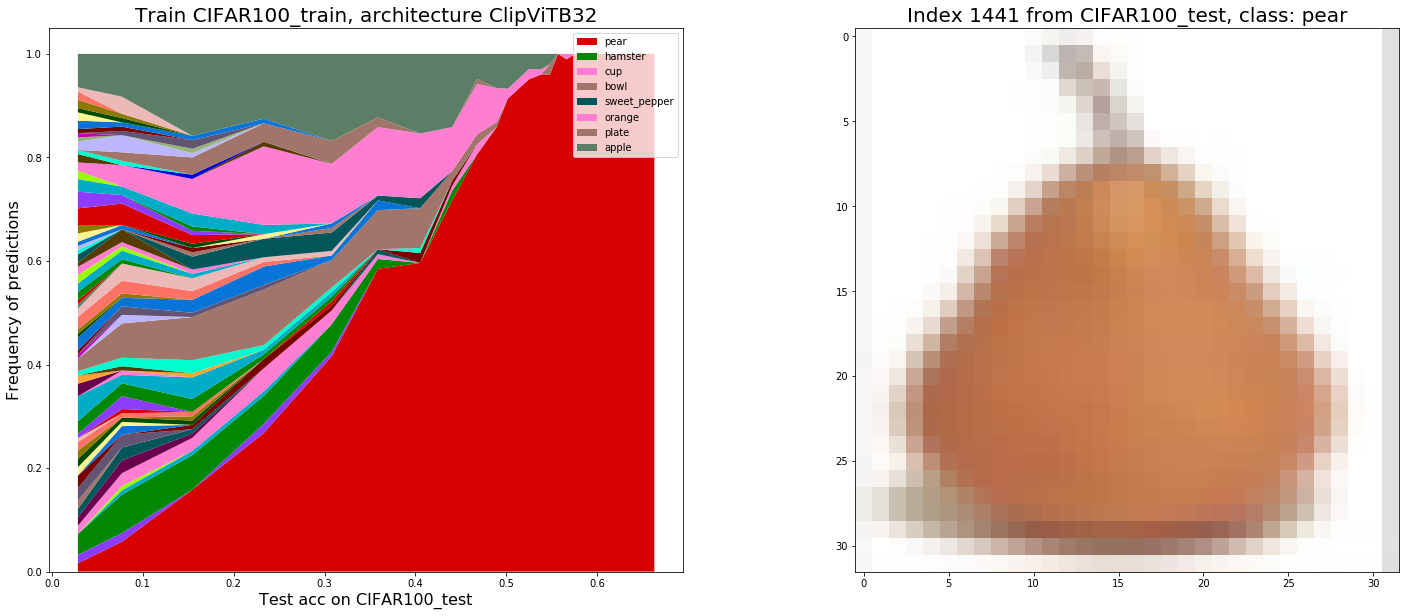

index 8229
probs
Top 5 are [75 40 27 45 32]
Prediction is skunk


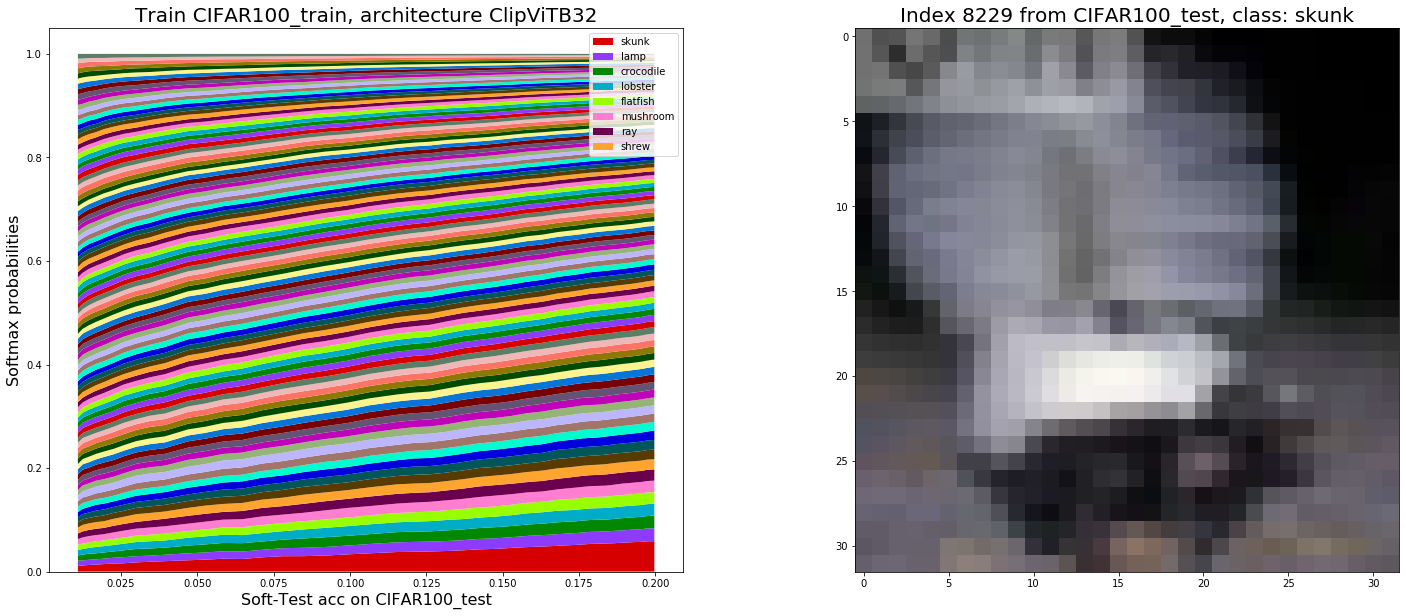

freqs
Top 5 are [75 35 25 26 27]
Prediction is skunk


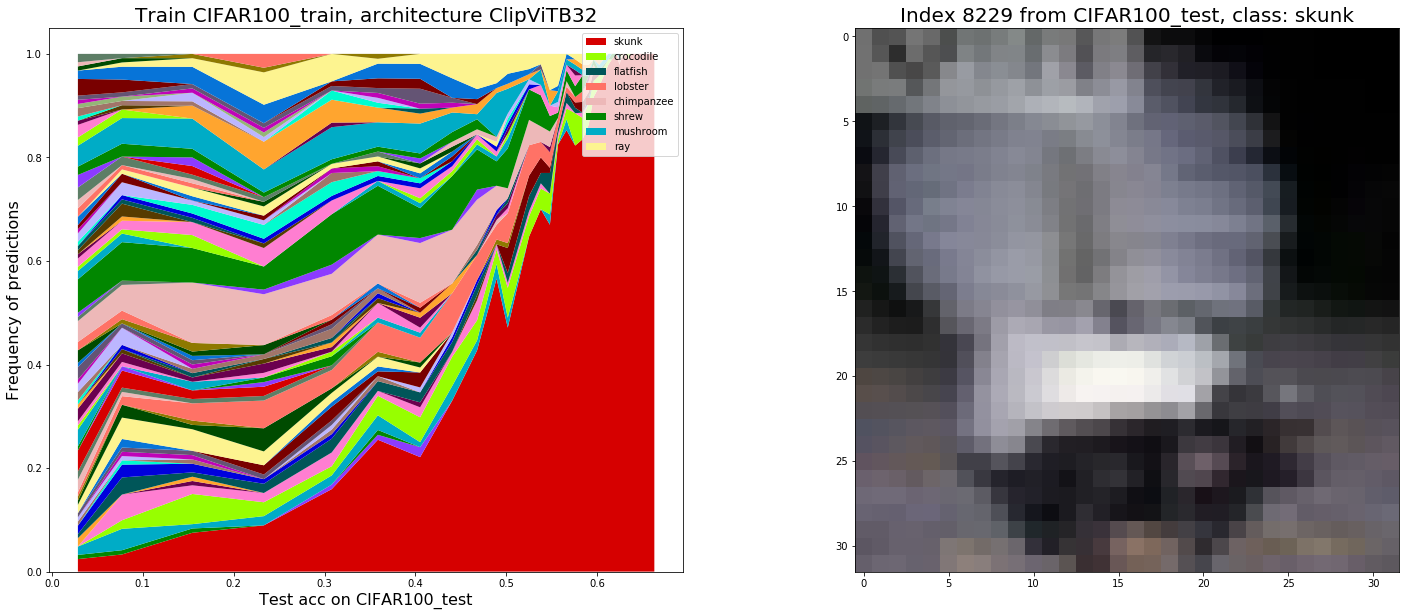

index 9486
probs
Top 5 are [ 8 48 41 58 84]
Prediction is bicycle


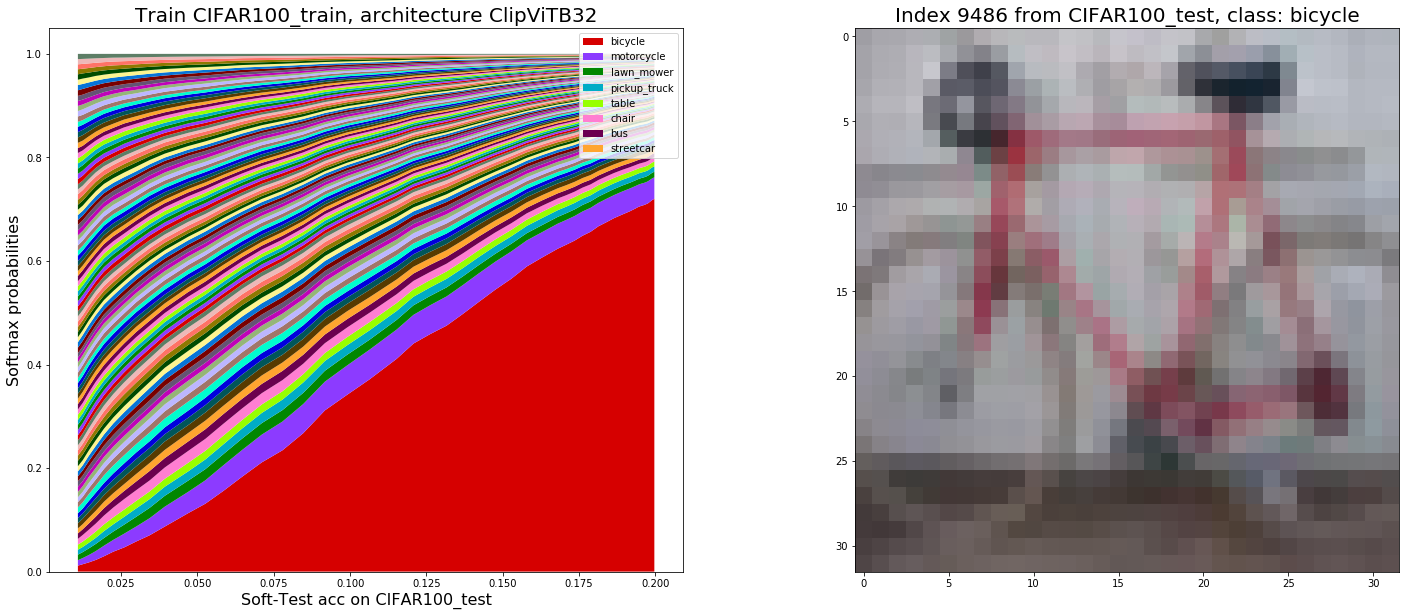

freqs
Top 5 are [ 8 99 37 27 28]
Prediction is bicycle


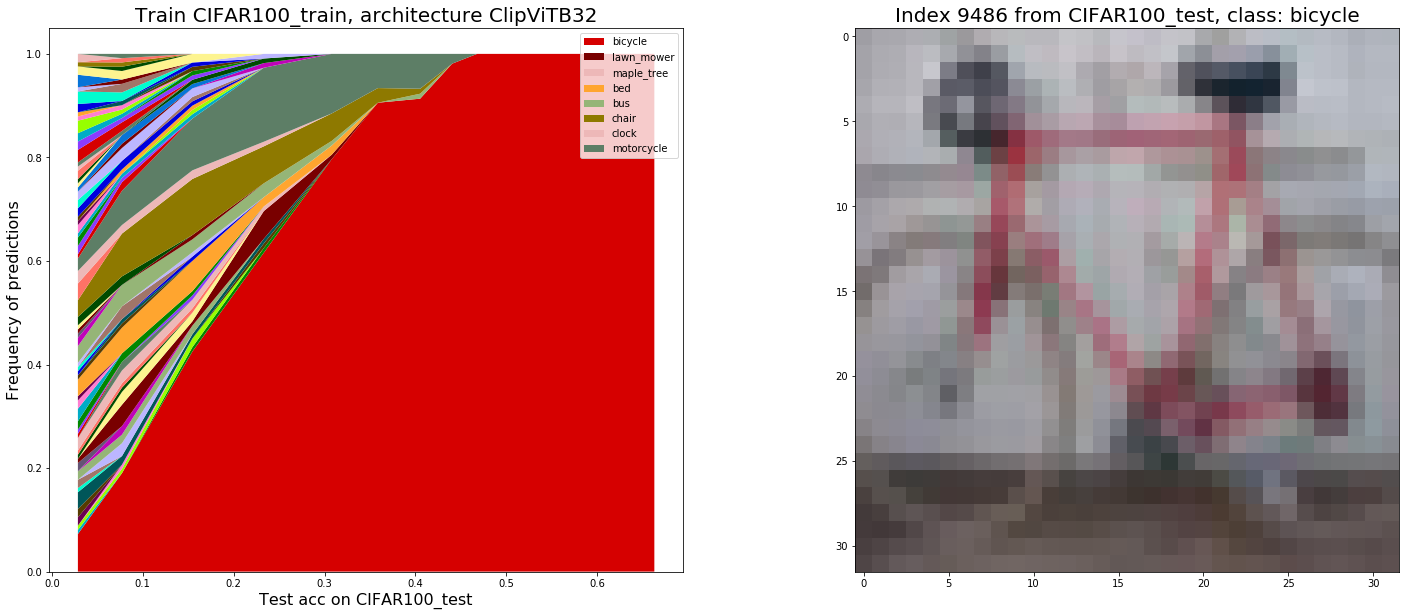

index 2492
probs
Top 5 are [85 89 69 58 27]
Prediction is tank


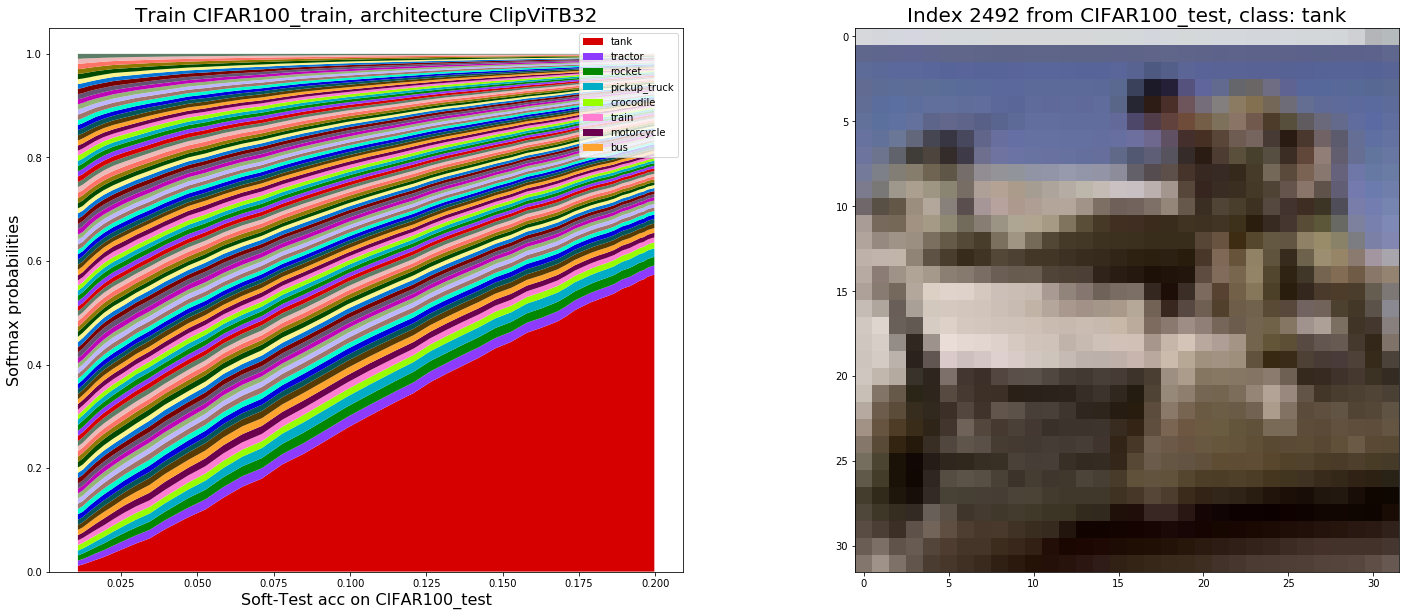

freqs
Top 5 are [85 99 35 26 27]
Prediction is tank


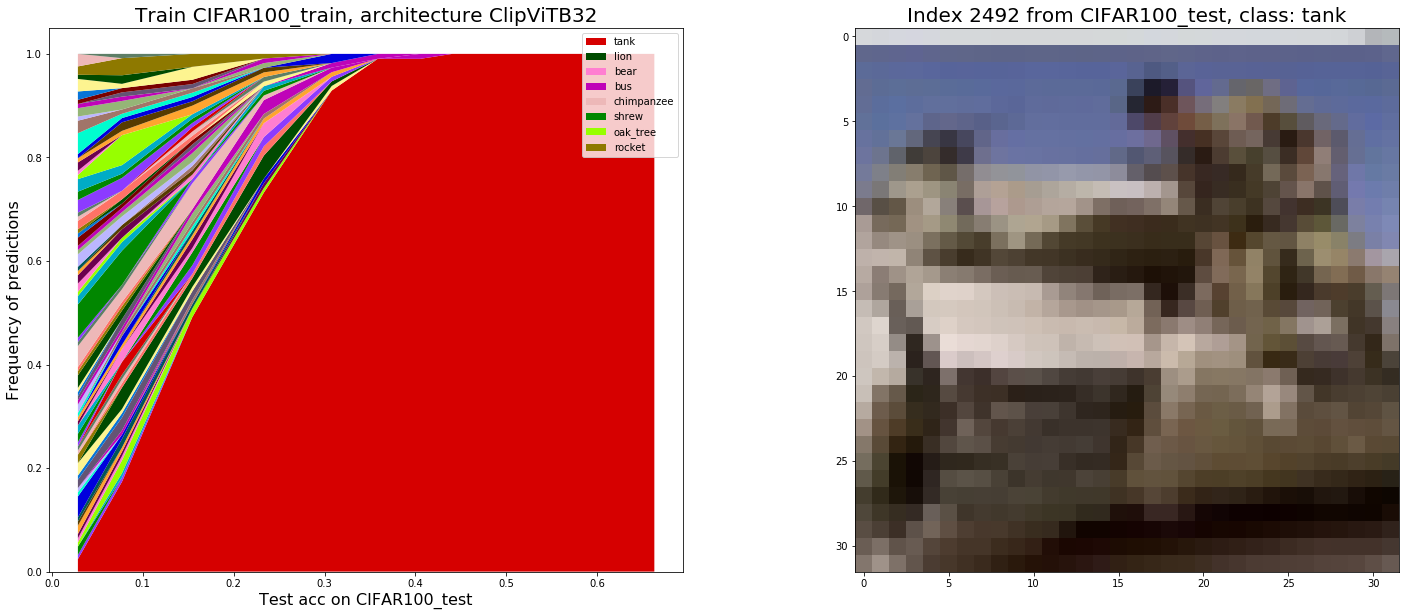

index 3118
probs
Top 5 are [21  3 75 97  4]
Prediction is chimpanzee


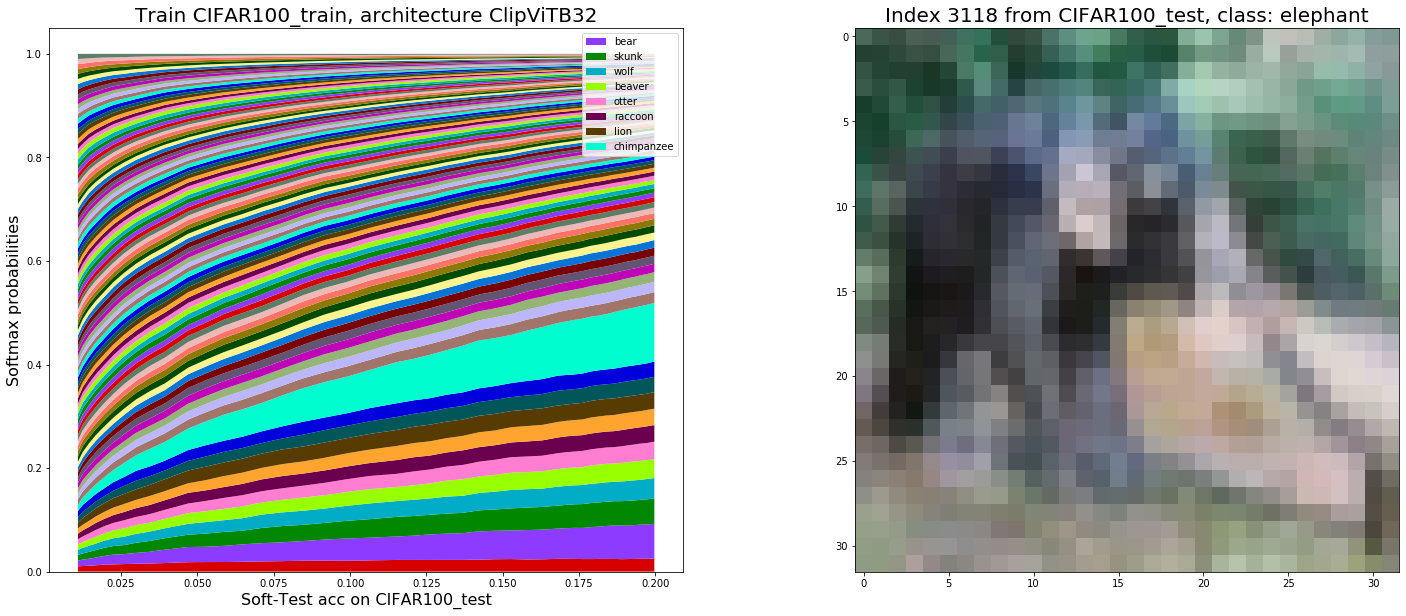

freqs
Top 5 are [21 99 36 27 28]
Prediction is chimpanzee


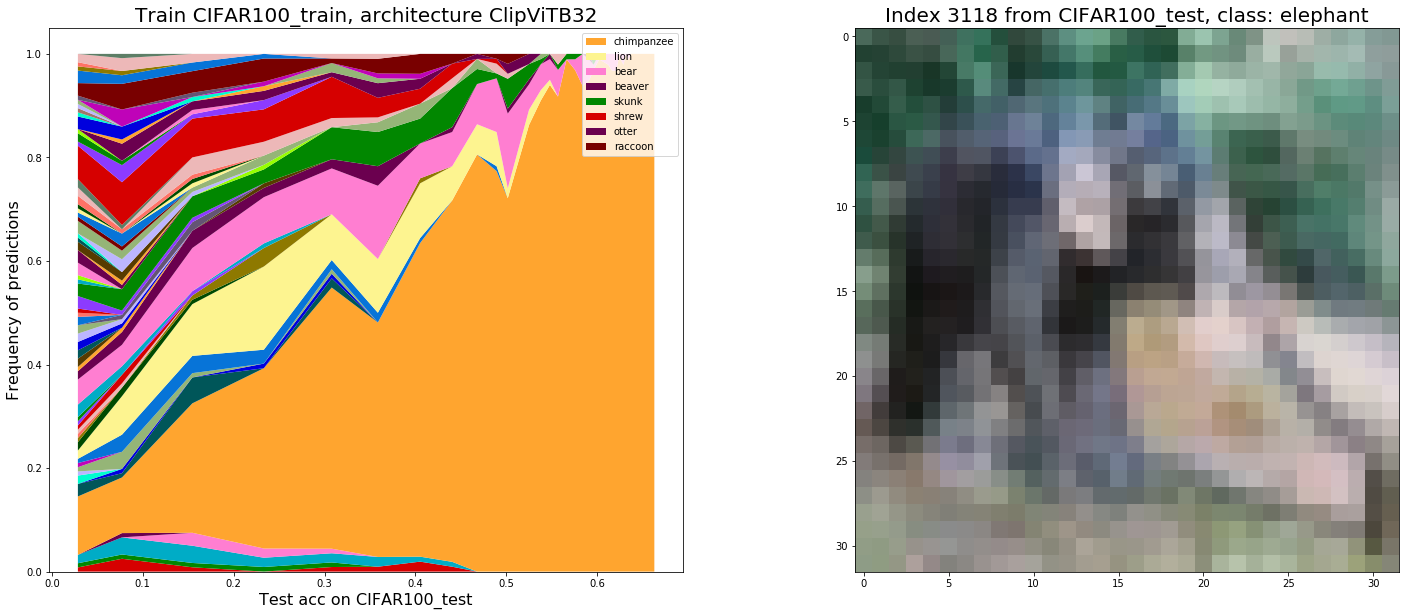

In [172]:
for idx in indices:
    stackplot(idx, types=["probs", "freqs"])

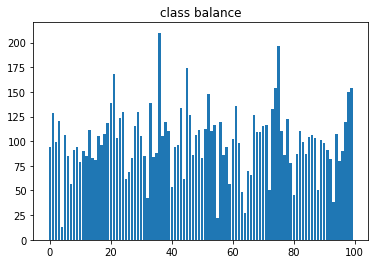

In [171]:
ypred = np.argmax(grouped[name]['ClipViTB32']["probs"][:, :, -1], axis=1)
counts = [np.sum(ypred == i) for i in range(100)]
plt.bar(np.arange(100), counts)
plt.title('class balance');

In [167]:
classes[ypred[indices[0]]]

'train'